# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from sklearn.metrics.scorer import make_scorer
from sklearn.dummy import DummyRegressor
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Начнем с предобработки данных, перед нами следующий план действий:

1) Необходимо предобразовать столбцы с датами в корректный формат

2) Необходимо исследовать пропуски в данных и исследовать нет ли у нас закономерностей для их заполнения. В том числе удалить строки с нулевой ценой - поскольку это целевой признак и нам необходимо его предсказывать, будет неправильно его усреднять или чем либо заменять.

3) Проверить аномальные значения (нулевые мощность, месяц регистрации, год регистрации выше возможного)

4) Привести к общему виду категориальные признаки если в данных есть отличающиеся

5) Далее проверим корреляцию, и уберем столбцы с корреляцией ~90% или больше. На данный момент я вижу что столбцы с датой создания анкеты и выгрузки анкеты из базы копируют друг друга.

6) Перевести категориальные признаки к бинарному виду чтобы модели было проще учиться

7) Если столбцы PostalCode, LastSeen, RegistrationMonth и DateCrawled к концу предобработки данных будут все еще на месте, то нужно будет взять их на карандаш, на мой взгляд данные признаки никаким образом не влияют на цену машины и просто создают лишний шум, но мое мнение может быть ошибочным. Поэтому на этапе обучения моделей, имеет смысл попробовать, будут ли модели лучше учиться при удалении этих признаков из наших данных.

In [5]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = '%Y-%m-%dT%H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = '%Y-%m-%dT%H:%M:%S')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format = '%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null datetime64[ns]
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 43.3+ MB


Теперь пропуски. Начнем с исключения нулевой цены а дальше по порядку.

In [6]:
df = df.drop(index = df.query('Price == 0').index).reset_index()
df = df.drop(['index'], axis = 1)
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,343597.000000,343597.000000,343597.000000,343597.000000,343597.000000,343597.0,343597.000000
mean,4555.121974,2004.089797,111.000192,128337.616452,5.777891,0.0,50683.358915
std,4515.058553,78.413225,188.177974,37521.047429,3.698186,0.0,25744.205799
min,1.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30449.000000
50%,2890.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
#VehicleType
df.query('VehicleType.isna()').head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
15,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
21,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
25,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
30,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
34,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50
36,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
46,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44
49,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08
50,2016-04-04 10:57:36,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04,0,34454,2016-04-06 12:45:43


Я не вижу каких либо закономерностей, между типом и другими признаками, зато вижу что есть много строк где 2 и более пропусков, я считаю что для более чистых данных следует избавиться от таких строк. У нас достаточно большая выборка чтобы мы могли себе позволить избавиться от части "грязных" данных.

In [8]:
df = df.drop(index = df.query('(VehicleType.isna() and Gearbox.isna()) or (VehicleType.isna() and Power == 0) or (VehicleType.isna() and RegistrationMonth == 0) or (VehicleType.isna() and FuelType.isna()) or (VehicleType.isna() and NotRepaired.isna()) or (VehicleType.isna() and Model.isna())').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314464 entries, 0 to 314463
Data columns (total 16 columns):
DateCrawled          314464 non-null datetime64[ns]
Price                314464 non-null int64
VehicleType          309847 non-null object
RegistrationYear     314464 non-null int64
Gearbox              305193 non-null object
Power                314464 non-null int64
Model                302527 non-null object
Kilometer            314464 non-null int64
RegistrationMonth    314464 non-null int64
FuelType             299957 non-null object
Brand                314464 non-null object
NotRepaired          266572 non-null object
DateCreated          314464 non-null datetime64[ns]
NumberOfPictures     314464 non-null int64
PostalCode           314464 non-null int64
LastSeen             314464 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 38.4+ MB


In [9]:
#Gearbox
df.query('Gearbox.isna()').head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
13,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
27,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
58,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
94,2016-04-03 03:57:26,350,small,1998,NaN,0,corsa,150000,2,petrol,opel,NaN,2016-04-03,0,82110,2016-04-03 08:53:37
129,2016-03-27 20:47:22,6799,small,2009,NaN,60,NaN,20000,5,petrol,volkswagen,no,2016-03-27,0,89077,2016-03-27 20:47:22
137,2016-03-28 10:50:04,1495,wagon,2001,NaN,64,NaN,150000,9,gasoline,volkswagen,NaN,2016-03-28,0,99086,2016-04-04 11:45:46
160,2016-03-16 15:51:08,14000,sedan,2008,NaN,235,NaN,150000,0,NaN,bmw,no,2016-02-12,0,95131,2016-04-07 14:56:12
170,2016-03-08 09:56:53,3200,wagon,2006,NaN,0,a3,150000,11,gasoline,audi,no,2016-03-08,0,41748,2016-03-08 09:56:53
180,2016-03-13 00:56:50,2250,small,2001,NaN,41,fortwo,150000,10,gasoline,smart,no,2016-03-13,0,78224,2016-03-30 01:47:18
205,2016-03-26 10:48:12,130,wagon,1998,NaN,0,e_klasse,150000,0,NaN,mercedes_benz,NaN,2016-03-26,0,22047,2016-04-05 22:15:49


Мне кажется я просто продолжу чистить пропуски в такой же логике, поскольку каких то очевидных закономерностей здесь нет, если пропусков в строке более двух то удаляем строку.

In [10]:
df = df.drop(index = df.query('(Gearbox.isna() and Power == 0) or (Gearbox.isna() and RegistrationMonth == 0) or (Gearbox.isna() and FuelType.isna()) or (Gearbox.isna() and NotRepaired.isna()) or (Gearbox.isna() and Model.isna())').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307263 entries, 0 to 307262
Data columns (total 16 columns):
DateCrawled          307263 non-null datetime64[ns]
Price                307263 non-null int64
VehicleType          302646 non-null object
RegistrationYear     307263 non-null int64
Gearbox              305193 non-null object
Power                307263 non-null int64
Model                296267 non-null object
Kilometer            307263 non-null int64
RegistrationMonth    307263 non-null int64
FuelType             294649 non-null object
Brand                307263 non-null object
NotRepaired          263325 non-null object
DateCreated          307263 non-null datetime64[ns]
NumberOfPictures     307263 non-null int64
PostalCode           307263 non-null int64
LastSeen             307263 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 37.5+ MB


In [11]:
#Power
df.query('Power == 0').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
43,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
44,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26,0,56759,2016-04-01 23:17:27
56,2016-03-08 01:36:42,800,small,1993,manual,0,polo,150000,3,petrol,volkswagen,no,2016-03-08,0,8258,2016-04-05 23:46:00
74,2016-03-23 11:53:21,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN,2016-03-23,0,40210,2016-03-23 11:53:21
80,2016-03-11 19:00:25,4290,bus,2008,manual,0,combo,150000,2,gasoline,opel,no,2016-03-11,0,23568,2016-04-05 22:45:32


Мощность также зависит от модификации которая нам не дана, поэтому точно заполнить ее по имеющимся признакам мы не сможем. Оставить пропущенные значения в этом столбце тоже нельзя, поскольку это важный технический параметр который имеет числовое выражение, кроме того мощность моделей имеет достаточно большой разброс, поэтому считаю что необходимо удалить все строки где не заполнен данный признак.

In [12]:
df = df.drop(index = df.query('Power == 0').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288383 entries, 0 to 288382
Data columns (total 16 columns):
DateCrawled          288383 non-null datetime64[ns]
Price                288383 non-null int64
VehicleType          283766 non-null object
RegistrationYear     288383 non-null int64
Gearbox              286313 non-null object
Power                288383 non-null int64
Model                279167 non-null object
Kilometer            288383 non-null int64
RegistrationMonth    288383 non-null int64
FuelType             278120 non-null object
Brand                288383 non-null object
NotRepaired          252185 non-null object
DateCreated          288383 non-null datetime64[ns]
NumberOfPictures     288383 non-null int64
PostalCode           288383 non-null int64
LastSeen             288383 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 35.2+ MB


In [13]:
#model
df.query('Model.isna()').head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
45,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
62,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
106,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
149,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27,0,83317,2016-04-07 08:17:08
216,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29,0,32791,2016-04-06 20:16:34
281,2016-03-08 08:57:34,5500,small,2012,manual,68,NaN,40000,12,NaN,peugeot,no,2016-03-08,0,24536,2016-03-21 21:44:28
329,2016-03-26 21:49:45,13950,other,2011,manual,140,NaN,60000,11,gasoline,alfa_romeo,no,2016-03-26,0,86830,2016-04-06 14:15:39
343,2016-03-20 20:45:27,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no,2016-03-20,0,90562,2016-04-03 04:17:08
347,2016-04-02 17:54:29,5800,bus,2007,manual,105,NaN,150000,11,gasoline,volkswagen,yes,2016-04-02,0,31319,2016-04-04 15:47:39


In [14]:
df = df.drop(index = df.query('(Model.isna() and RegistrationMonth == 0) or (Model.isna() and FuelType.isna()) or (Model.isna() and NotRepaired.isna())').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284098 entries, 0 to 284097
Data columns (total 16 columns):
DateCrawled          284098 non-null datetime64[ns]
Price                284098 non-null int64
VehicleType          279481 non-null object
RegistrationYear     284098 non-null int64
Gearbox              282028 non-null object
Power                284098 non-null int64
Model                279167 non-null object
Kilometer            284098 non-null int64
RegistrationMonth    284098 non-null int64
FuelType             275468 non-null object
Brand                284098 non-null object
NotRepaired          250582 non-null object
DateCreated          284098 non-null datetime64[ns]
NumberOfPictures     284098 non-null int64
PostalCode           284098 non-null int64
LastSeen             284098 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 34.7+ MB


In [15]:
#RegistrationMonth
df.query('RegistrationMonth == 0').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
7,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
29,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
60,2016-04-01 22:39:35,250,wagon,2000,manual,155,156,150000,0,petrol,alfa_romeo,yes,2016-04-01,0,8396,2016-04-05 20:18:14
79,2016-03-20 12:59:39,300,convertible,1992,manual,105,escort,150000,0,NaN,ford,yes,2016-03-20,0,88515,2016-04-06 13:15:58
99,2016-03-26 19:37:55,300,small,2000,manual,54,corsa,150000,0,petrol,opel,NaN,2016-03-26,0,59379,2016-04-06 09:15:51


In [16]:
df = df.drop(index = df.query('(RegistrationMonth == 0 and FuelType.isna()) or (RegistrationMonth == 0 and NotRepaired.isna())').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277411 entries, 0 to 277410
Data columns (total 16 columns):
DateCrawled          277411 non-null datetime64[ns]
Price                277411 non-null int64
VehicleType          272794 non-null object
RegistrationYear     277411 non-null int64
Gearbox              275341 non-null object
Power                277411 non-null int64
Model                272480 non-null object
Kilometer            277411 non-null int64
RegistrationMonth    277411 non-null int64
FuelType             271034 non-null object
Brand                277411 non-null object
NotRepaired          249385 non-null object
DateCreated          277411 non-null datetime64[ns]
NumberOfPictures     277411 non-null int64
PostalCode           277411 non-null int64
LastSeen             277411 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 33.9+ MB


In [17]:
#FuelType
df.query('FuelType.isna()').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
10,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21,0,90762,2016-03-23 02:50:54
30,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30,0,33649,2016-04-03 11:44:49
70,2016-03-26 15:38:12,6450,bus,2008,manual,84,transporter,150000,12,NaN,volkswagen,no,2016-03-26,0,44623,2016-04-06 03:17:37
87,2016-03-23 12:54:52,400,sedan,2000,manual,144,omega,150000,10,NaN,opel,yes,2016-03-23,0,45968,2016-04-05 12:45:13
116,2016-03-08 19:58:07,1499,small,2002,manual,140,a_klasse,150000,10,NaN,mercedes_benz,no,2016-03-08,0,16727,2016-03-10 17:44:36


In [18]:
df = df.drop(index = df.query('(FuelType.isna() and NotRepaired.isna())').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275526 entries, 0 to 275525
Data columns (total 16 columns):
DateCrawled          275526 non-null datetime64[ns]
Price                275526 non-null int64
VehicleType          270909 non-null object
RegistrationYear     275526 non-null int64
Gearbox              273456 non-null object
Power                275526 non-null int64
Model                270595 non-null object
Kilometer            275526 non-null int64
RegistrationMonth    275526 non-null int64
FuelType             271034 non-null object
Brand                275526 non-null object
NotRepaired          249385 non-null object
DateCreated          275526 non-null datetime64[ns]
NumberOfPictures     275526 non-null int64
PostalCode           275526 non-null int64
LastSeen             275526 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(7), object(6)
memory usage: 33.6+ MB


In [19]:
df.query('NotRepaired.isna()').head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
6,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15,0,37269,2016-04-01 13:16:16
30,2016-03-24 00:52:09,12500,sedan,2006,auto,231,5er,150000,11,gasoline,bmw,NaN,2016-03-23,0,46119,2016-04-04 16:18:19
32,2016-03-17 12:44:43,3900,small,2008,auto,61,fortwo,80000,6,petrol,smart,NaN,2016-03-17,0,21073,2016-03-19 11:46:17


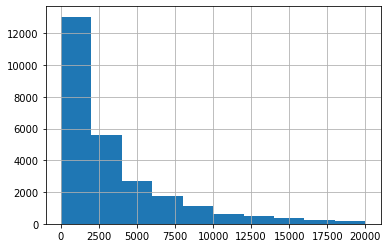

In [20]:
df.query('NotRepaired.isna()')['Price'].hist()

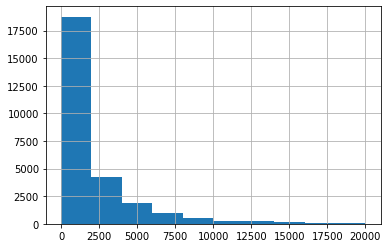

In [21]:
df.query('NotRepaired == "yes"')['Price'].hist()

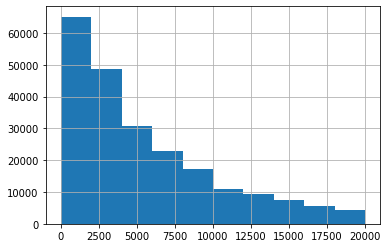

In [22]:
df.query('NotRepaired == "no"')['Price'].hist()

Строки с пропущенными значениями имеют цены выше чем ремонтированные машины и ниже чем не ремонтированные, поэтому утверждать что все машины с пропущенными значениями были в ремонте нельзя, а значит просто оставляем пропуски.

Теперь переходим к поиску аномальных значений.

In [23]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,275526.000000,275526.000000,275526.000000,275526.000000,275526.000000,275526.0,275526.000000
mean,5046.251512,2002.996614,124.765039,127772.478822,6.248768,0.0,51373.638158
std,4655.026959,12.153215,182.909652,36848.214016,3.435533,0.0,25778.318242
min,1.000000,1600.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1490.000000,1999.000000,80.000000,125000.000000,3.000000,0.0,30989.000000
50%,3450.000000,2003.000000,114.000000,150000.000000,6.000000,0.0,50668.000000
75%,7300.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72202.000000
max,20000.000000,6500.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Для начала я вижу что можно удалить столбец NumberOfPictures, одинаковые значения модели не нужны.

Далее нужно построить гистограммы по цене, году регистрации и мощности чтобы убрать выбросы.

По километрам мы видим что стоит ограничение в 150000, логично предположить что заказчик считает что свыше этого расстояния, этот параметр на цену уже не влияет, поэтому его можно оставить как есть. 

Месяц регистрации 0 - это пропущенные значения, корректно мы их не заполним, просто смиримся с этим фактом.

In [24]:
df = df.drop(['NumberOfPictures'], axis = 1)
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04,33775,2016-04-06 19:17:07


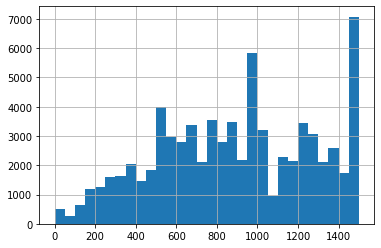

In [25]:
#df['Price'].hist(bins = 30, range = (0, 20000))
df['Price'].hist(bins = 30, range = (0, 1500))

Тут аномалии могут быть только снизу, вверху значение вероятно ограничено 20000, распространение идет равномерно поэтому этой части данных я склонен верить. А вот снизу есть слишком маленькие значения, считаю глядя на диаграмму, что от значений цены менее 100 стоит избавиться.

In [26]:
df = df.drop(index = df.query('Price < 100').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274737 entries, 0 to 274736
Data columns (total 15 columns):
DateCrawled          274737 non-null datetime64[ns]
Price                274737 non-null int64
VehicleType          270161 non-null object
RegistrationYear     274737 non-null int64
Gearbox              272677 non-null object
Power                274737 non-null int64
Model                269829 non-null object
Kilometer            274737 non-null int64
RegistrationMonth    274737 non-null int64
FuelType             270288 non-null object
Brand                274737 non-null object
NotRepaired          248756 non-null object
DateCreated          274737 non-null datetime64[ns]
PostalCode           274737 non-null int64
LastSeen             274737 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(6), object(6)
memory usage: 31.4+ MB


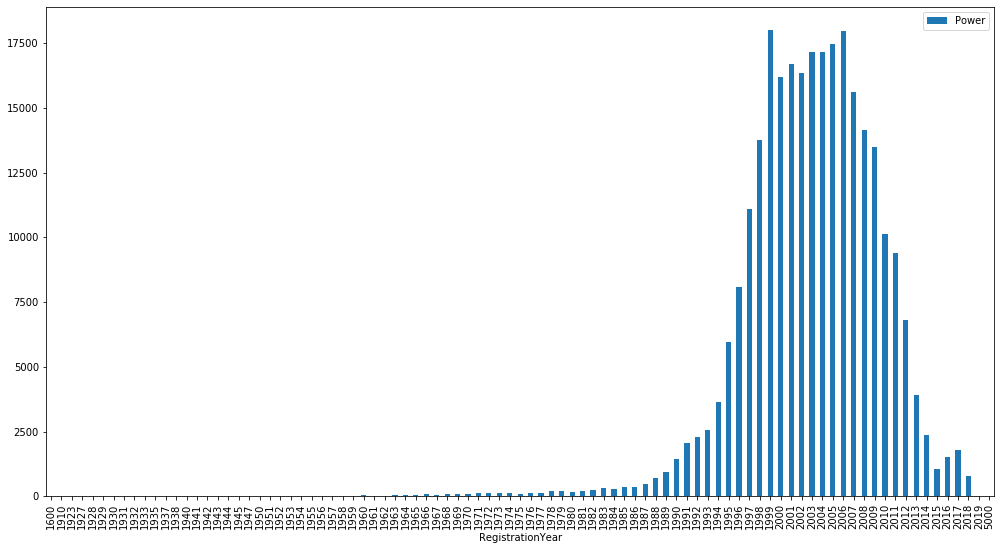

In [27]:
df.pivot_table(index = 'RegistrationYear', values = 'Power', aggfunc = 'count').plot(kind = 'bar', figsize = (17, 9))

Я думаю необходимо убрать все что больше 2018 года и меньше 1985.

In [28]:
df = df.drop(index = df.query('RegistrationYear > 2018 or RegistrationYear < 1985').index).reset_index()
df = df.drop(['index'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271610 entries, 0 to 271609
Data columns (total 15 columns):
DateCrawled          271610 non-null datetime64[ns]
Price                271610 non-null int64
VehicleType          267047 non-null object
RegistrationYear     271610 non-null int64
Gearbox              269579 non-null object
Power                271610 non-null int64
Model                267101 non-null object
Kilometer            271610 non-null int64
RegistrationMonth    271610 non-null int64
FuelType             267222 non-null object
Brand                271610 non-null object
NotRepaired          245970 non-null object
DateCreated          271610 non-null datetime64[ns]
PostalCode           271610 non-null int64
LastSeen             271610 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(6), object(6)
memory usage: 31.1+ MB


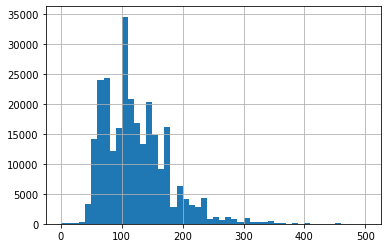

In [29]:
df['Power'].hist(bins = 50, range = (0, 500))

Уберем все значения ниже 40 и больше 350, модель все равно не сможет предсказывать редко встречающиеся значения, а значит будем ориентироваться на большинство.

In [30]:
df = df.drop(index = df.query('Power > 350 or Power < 40').index).reset_index()
df = df.drop(['index'], axis = 1)
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,270023.000000,270023.000000,270023.000000,270023.000000,270023.000000,270023.000000
mean,5017.225981,2003.314088,121.232621,128164.526726,6.259000,51394.382564
std,4622.400891,5.635547,51.422667,36447.683318,3.435604,25757.930060
min,100.000000,1985.000000,40.000000,5000.000000,0.000000,1067.000000
25%,1490.000000,1999.000000,80.000000,125000.000000,3.000000,31029.000000
50%,3400.000000,2003.000000,115.000000,150000.000000,6.000000,50676.000000
75%,7250.000000,2007.000000,150.000000,150000.000000,9.000000,72184.000000
max,20000.000000,2018.000000,350.000000,150000.000000,12.000000,99998.000000


Теперь разберемся с категориальными признаками, нужно проверить нет ли опечаток и по разному записанных типов и потом превратить их в бинарные столбцы. Под раздачу попадают признаки: VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired.

In [31]:
df['VehicleType'].value_counts()

sedan          77446
small          64741
wagon          55697
bus            25126
convertible    17388
coupe          12833
suv            10275
other           1980
Name: VehicleType, dtype: int64

In [32]:
df['Gearbox'].value_counts()

manual    213422
auto       54587
Name: Gearbox, dtype: int64

In [33]:
df['Model'].value_counts()

golf                  22703
other                 17602
3er                   16401
polo                   9815
corsa                  9272
                      ...  
rangerover                3
601                       3
samara                    3
range_rover_evoque        2
serie_2                   1
Name: Model, Length: 248, dtype: int64

In [34]:
df['FuelType'].value_counts()

petrol      175188
gasoline     85331
lpg           4410
cng            472
hybrid         201
other           44
electric        33
Name: FuelType, dtype: int64

In [35]:
df['Brand'].value_counts()

volkswagen        58003
bmw               29930
opel              29120
mercedes_benz     25103
audi              23711
ford              18798
renault           12746
peugeot            8619
fiat               6720
seat               5482
skoda              4765
mazda              4369
smart              4199
citroen            3883
toyota             3844
nissan             3730
hyundai            2965
mini               2885
volvo              2614
mitsubishi         2253
honda              2139
kia                1979
suzuki             1811
alfa_romeo         1773
chevrolet          1285
chrysler           1059
sonstige_autos      965
dacia               773
subaru              569
daihatsu            544
jeep                514
porsche             473
saab                444
land_rover          424
daewoo              377
jaguar              375
lancia              327
rover               307
lada                131
trabant              15
Name: Brand, dtype: int64

In [36]:
df['NotRepaired'].value_counts()

no     218194
yes     26390
Name: NotRepaired, dtype: int64

В плане опечаток в данных все хорошо, но есть проблема что моделей очень много, некоторые из них встречаются в данных тысячами но большая часть единичные, поэтому нам не хватит данных чтобы модель могла находить разницу по большинству из них, скорее всего без него предсказания будут лучше.

Теперь поработаем с датами, я думаю что на продажу автомобиля день не влияет, а влияют года и месяцы, поэтому мы выведем их из столбцов с датами, а сами изначальные столбцы удалим.

Далее проверим корреляцию столбцов до того как их станет очень много после преобразования категориальных признаков в числовые с помощью OHE. Если будут столбцы с корреляцией более 90% - их удалим. Если все будет нормально то переходим к OHE.

In [37]:
df['DateCrawled_month'] = df['DateCrawled'].dt.month
df['DateCrawled_year'] = df['DateCrawled'].dt.year
df['DateCreated_month'] = df['DateCreated'].dt.month
df['DateCreated_year'] = df['DateCreated'].dt.year
df['LastSeen_month'] = df['LastSeen'].dt.month
df['LastSeen_year'] = df['LastSeen'].dt.year
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,NotRepaired,DateCreated,PostalCode,LastSeen,DateCrawled_month,DateCrawled_year,DateCreated_month,DateCreated_year,LastSeen_month,LastSeen_year
0,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,...,yes,2016-03-24,66954,2016-04-07 01:46:50,3,2016,3,2016,4,2016
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,...,NaN,2016-03-14,90480,2016-04-05 12:47:46,3,2016,3,2016,4,2016
2,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,...,no,2016-03-17,91074,2016-03-17 17:40:17,3,2016,3,2016,3,2016
3,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,...,no,2016-03-31,60437,2016-04-06 10:17:21,3,2016,3,2016,4,2016
4,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,...,yes,2016-04-04,33775,2016-04-06 19:17:07,4,2016,4,2016,4,2016


In [38]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,DateCrawled_month,DateCrawled_year,DateCreated_month,DateCreated_year,LastSeen_month,LastSeen_year
Price,1.000000,0.622076,0.512119,-0.405783,0.031969,0.062533,0.017511,NaN,0.015477,-0.003801,0.150529,NaN
RegistrationYear,0.622076,1.000000,0.139080,-0.425426,0.013200,0.031639,0.002490,NaN,0.000750,-0.000767,0.053817,NaN
Power,0.512119,0.139080,1.000000,0.106338,0.028571,0.054539,0.003918,NaN,0.002691,0.000003,0.060637,NaN
Kilometer,-0.405783,-0.425426,0.106338,1.000000,-0.005027,-0.012126,-0.004180,NaN,-0.003408,0.004655,-0.066202,NaN
RegistrationMonth,0.031969,0.013200,0.028571,-0.005027,1.000000,-0.002339,-0.004450,NaN,-0.004529,0.003616,-0.004245,NaN
PostalCode,0.062533,0.031639,0.054539,-0.012126,-0.002339,1.000000,0.011448,NaN,0.011141,0.001722,0.039545,NaN
DateCrawled_month,0.017511,0.002490,0.003918,-0.004180,-0.004450,0.011448,1.000000,NaN,0.969990,0.001918,0.377462,NaN
DateCrawled_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DateCreated_month,0.015477,0.000750,0.002691,-0.003408,-0.004529,0.011141,0.969990,NaN,1.000000,-0.179282,0.366662,NaN
DateCreated_year,-0.003801,-0.000767,0.000003,0.004655,0.003616,0.001722,0.001918,NaN,-0.179282,1.000000,-0.001367,NaN


In [39]:
df['DateCreated_year'].value_counts()

2016    270000
2015        23
Name: DateCreated_year, dtype: int64

In [40]:
df['DateCrawled_year'].value_counts()

2016    270023
Name: DateCrawled_year, dtype: int64

In [41]:
df['LastSeen_year'].value_counts()

2016    270023
Name: LastSeen_year, dtype: int64

In [42]:
df = df.drop(['DateCreated_year', 'DateCrawled_year', 'LastSeen_year', 'DateCreated_month', 'DateCrawled', 'DateCreated', 'LastSeen'], axis = 1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,DateCrawled_month,LastSeen_month
0,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954,3,4
1,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480,3,4
2,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,3,3
3,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,3,4
4,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775,4,4


In [43]:
df_num = pd.get_dummies(df, columns = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired', 'RegistrationMonth', 'DateCrawled_month', 'LastSeen_month'], drop_first=True)
df_num = df_num.drop(['Model'], axis = 1)
df_num.head()

,Price,RegistrationYear,Power,Kilometer,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,RegistrationMonth_5,RegistrationMonth_6,RegistrationMonth_7,RegistrationMonth_8,RegistrationMonth_9,RegistrationMonth_10,RegistrationMonth_11,RegistrationMonth_12,DateCrawled_month_4,LastSeen_month_4
0,18300,2011,190,125000,66954,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,9800,2004,163,125000,90480,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,1500,2001,75,150000,91074,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,3600,2008,69,90000,60437,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,650,1995,102,150000,33775,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1


И на этом с предобработкой данных я считаю можно закончить. Пора переходить к обучению моделей.

## Обучение моделей

Для обучения моделей мы должны:

1) разделить наши данные на тренировочную и тестовую выборки.

2) обучить несколько моделей, и подобрать к ним параметры. Пусть это будет решаюшее дерево, случайный лес, линейная регрессия, и LightGBM. Качество моделей согласно задания будем определять с помощью RMSE. Также при обучении выводить время выполнения ячейки.

3) Проверить как повлияет на обучение удаление столбцов Model, PostalCode, DateCrawled_month_4, LastSeen_month_4

In [44]:
features = df_num.drop('Price', axis = 1)
target = df_num['Price']
features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                       target, test_size = 0.25, random_state=12345)

In [45]:
%%time
best_result_1 = 10000
best_depth_1 = 0
for depth_1 in range(1, 50):
    model_1 = DecisionTreeRegressor(random_state = 12345, max_depth = depth_1)
    model_1.fit(features_train, target_train)
    answer_1 = model_1.predict(features_valid)
    result_1 = mean_squared_error(answer_1, target_valid) ** 0.5
    if result_1 < best_result_1:
        best_model_1 = model_1
        best_result_1 = result_1
        best_depth_1 = depth_1

print("Лучший результат:", best_result_1, "Глубина дерева:", best_depth_1)

Лучший результат: 1787.9838460368926 Глубина дерева: 15
CPU times: user 1min 57s, sys: 2.48 s, total: 1min 59s
Wall time: 2min


In [46]:
%%time
model_1_1 = DecisionTreeRegressor(random_state = 12345, max_depth = 15)
model_1_1.fit(features_train, target_train)

CPU times: user 2.05 s, sys: 36 ms, total: 2.09 s
Wall time: 2.1 s


DecisionTreeRegressor(criterion='mse', max_depth=15, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [47]:
%%time
answer_1_1 = model_1_1.predict(features_valid)
result_1_1 = mean_squared_error(answer_1_1, target_valid) ** 0.5
result_1_1

CPU times: user 24.1 ms, sys: 12.1 ms, total: 36.2 ms
Wall time: 34.6 ms


1787.9838460368926

In [48]:
my_scorer = make_scorer(mean_squared_error)

In [49]:
%%time
model_2 = RandomForestRegressor(random_state = 12345, n_estimators = 13, max_depth = 15)
np.mean(cross_val_score(model_2, features_train, target_train, scoring=my_scorer, cv = 4)) ** 0.5

CPU times: user 1min, sys: 208 ms, total: 1min 1s
Wall time: 1min 1s


1650.433628464765

In [50]:
%%time
model_2 = RandomForestRegressor(random_state = 12345, n_estimators = 13, max_depth = 15)
model_2.fit(features_train, target_train)

CPU times: user 17.4 s, sys: 55.9 ms, total: 17.5 s
Wall time: 18.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=13,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [51]:
%%time
answer_2 = model_2.predict(features_valid)
result_2 = mean_squared_error(answer_2, target_valid) ** 0.5
result_2

CPU times: user 177 ms, sys: 16 ms, total: 193 ms
Wall time: 199 ms


1595.332859112454

In [52]:
%%time
model_3 = LinearRegression()
model_3.fit(features_train, target_train)

CPU times: user 2.74 s, sys: 850 ms, total: 3.59 s
Wall time: 3.54 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [53]:
%%time
answer_3 = model_3.predict(features_valid)
result_3 = mean_squared_error(answer_3, target_valid) ** 0.5
result_3

CPU times: user 39 ms, sys: 44.1 ms, total: 83.1 ms
Wall time: 120 ms


2475.1232339735166

In [54]:
%%time
model_4 = LGBMRegressor(num_leaves = 70, learning_rate=0.1)
model_4.fit(features_train, target_train)

CPU times: user 11.9 s, sys: 111 ms, total: 12 s
Wall time: 12.2 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=70, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [55]:
%%time
answer_4 = model_4.predict(features_valid)
result_4 = mean_squared_error(answer_4, target_valid) ** 0.5
result_4

CPU times: user 733 ms, sys: 3.17 ms, total: 736 ms
Wall time: 705 ms


1524.612056191437

## Анализ моделей

В итоге лучшие результаты по точности показала модель с градиентным бустингом, хоть и обогнала модель случайного леса всего чуть-чуть, по скорости обучения градиентный бустинг также выигрывает, единственное преимущество случайного леса в том, что он быстрее предсказывает. Самой быстрой и по обучению и по предсказанию оказалась модель решающего дерева, она успела обучиться почти за 2 секунды, и показала результат не сильно уступающий другим по качеству. Самый слабый результат в части точности из исследуемых показала себя линейная регрессия, и при этом отстала от решающего древа по скорости.
Как итог, я считаю, что заказчику нужно будет предложить два варианта: и решающее древо и градиентный бустинг, смотря что ему важнее скорость или точность на примере имеющихся результатов. 